In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.cluster import KMeans
from scipy.ndimage import center_of_mass
from scipy.ndimage import label

## Read image and convert to RGB

In [18]:
def imshow(img):
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

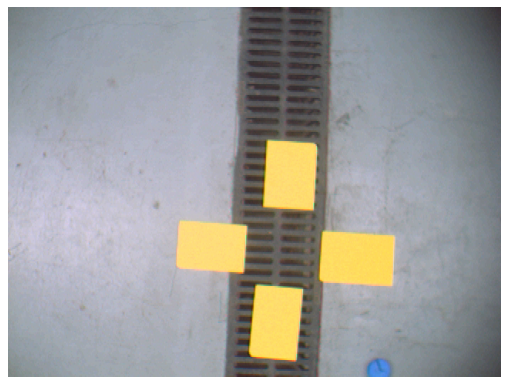

In [19]:
img_path = "yellowtargets.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imshow(img)

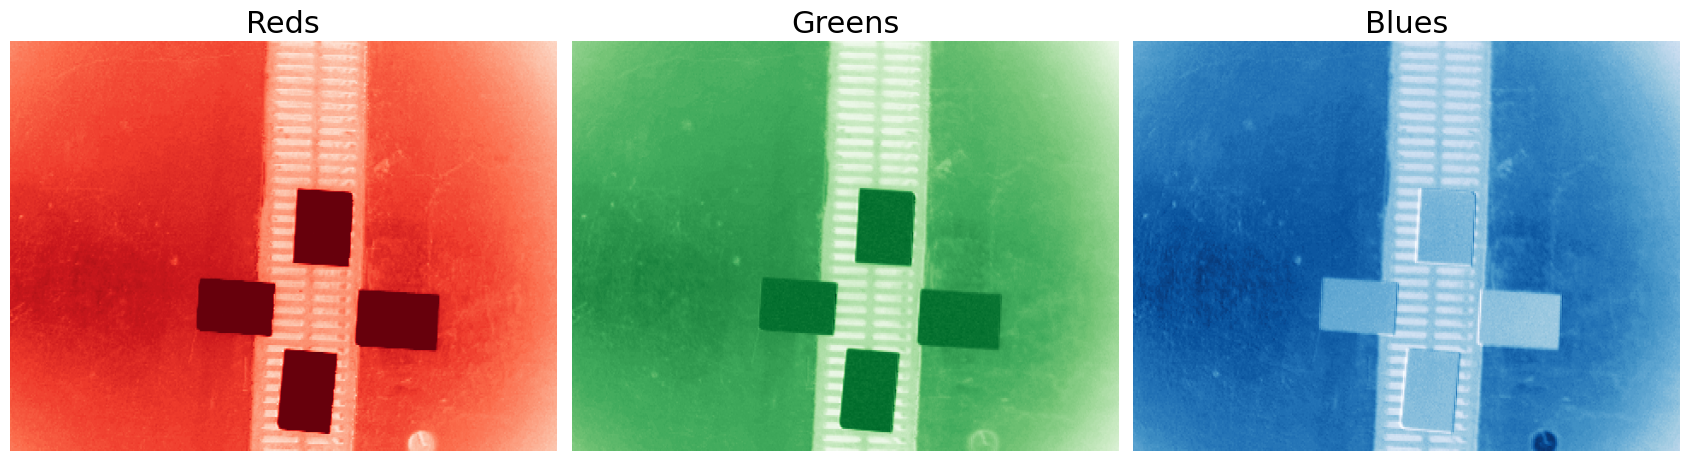

In [20]:
def rgb_splitter(image):
    rgb_list = ['Reds','Greens','Blues']
    fig, ax = plt.subplots(1, 3, figsize=(17,7), sharey = True)
    for i in range(3):
        ax[i].imshow(image[:,:,i], cmap = rgb_list[i])
        ax[i].set_title(rgb_list[i], fontsize = 22)
        ax[i].axis('off')
    fig.tight_layout()

rgb_splitter(img)

In [21]:
img = cv2.GaussianBlur(img, (5, 5), 1.5)

## Chromaticity and chromatic plane

In [22]:
Y = img.sum(axis=2) # R + G + B
r = img[:,:,0] / Y
g = img[:,:,1] / Y

one_matrix = np.ones_like(float, shape=r.shape)
b = one_matrix- (r + g)

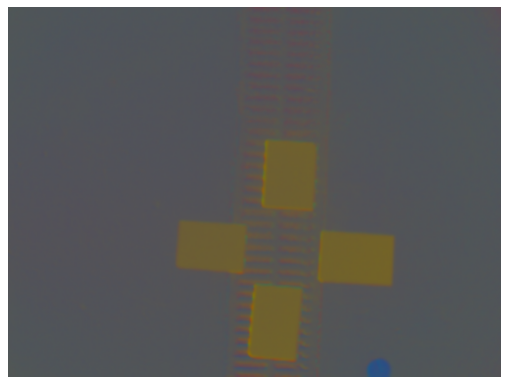

In [23]:
img_chromatic_rgb = cv2.merge([np.uint8(r*255),
                               np.uint8(g*255),
                               np.uint8(b*255)]) 
imshow(img_chromatic_rgb)

In [24]:
def RG_Chroma_plotter(red,green):
    p_color = [(r, g, 1-r-g) for r,g in 
               zip(red.flatten(),green.flatten())]
    norm = colors.Normalize(vmin=0,vmax=1.)
    norm.autoscale(p_color)
    p_color = norm(p_color).tolist()
    
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = fig.add_subplot(111)
    ax.scatter(red.flatten(), 
                green.flatten(), 
                c = p_color, alpha = 0.40)
    ax.set_xlabel('Red Channel', fontsize = 20)
    ax.set_ylabel('Green Channel', fontsize = 20)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.show()

# RG_Chroma_plotter(r, g)

## Kmeans

In [25]:
# Flatten the chromaticity coordinates for clustering
chromaticity = np.float32(np.stack([r.flatten(), g.flatten()], axis=1))

In [26]:
kmeans = KMeans(n_clusters=7, random_state=42).fit(chromaticity)
labels = kmeans.labels_.reshape(r.shape)

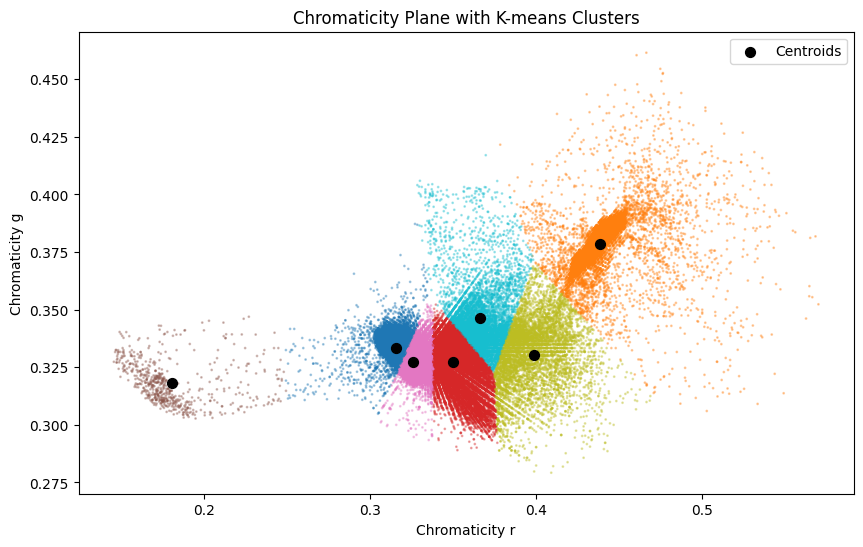

In [27]:
# Plot the chromaticity plane with clusters
plt.figure(figsize=(10, 6))
plt.scatter(chromaticity[:, 0], chromaticity[:, 1], c=kmeans.labels_, s=1, alpha=0.35, cmap='tab10')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="black", marker="o", s=50, label="Centroids")
plt.xlabel("Chromaticity r")
plt.ylabel("Chromaticity g")
plt.title("Chromaticity Plane with K-means Clusters")
plt.legend()
plt.show()

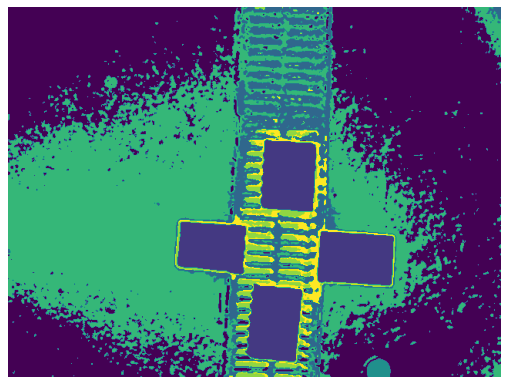

In [28]:
predictions = kmeans.predict(chromaticity)
img_labels = predictions.reshape(r.shape) 
imshow(img_labels)

Getting yellow cluster using pixel reference

In [29]:
yellow_pixel_reference = img_chromatic_rgb[400, 350]
yellow_pixel_reference

array([111,  96,  46], dtype=uint8)

In [30]:
yellow_cluster = img_labels[400, 350]
print(yellow_cluster)

1


Creating binary image with target yellow pixels class

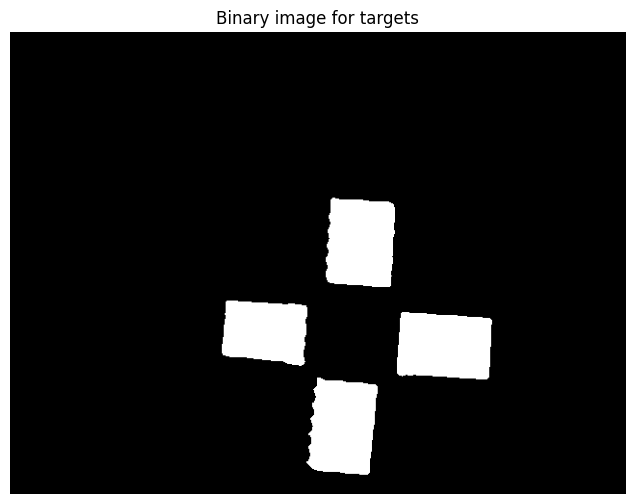

In [ ]:
binary_image = (labels == yellow_cluster).astype(np.uint8)

plt.figure(figsize=(10, 6))
plt.imshow(binary_image, cmap="gray")
plt.title("Binary image for targets")
plt.axis("off")
plt.show()

## Centroid targets

Number of yellow targets found: 4


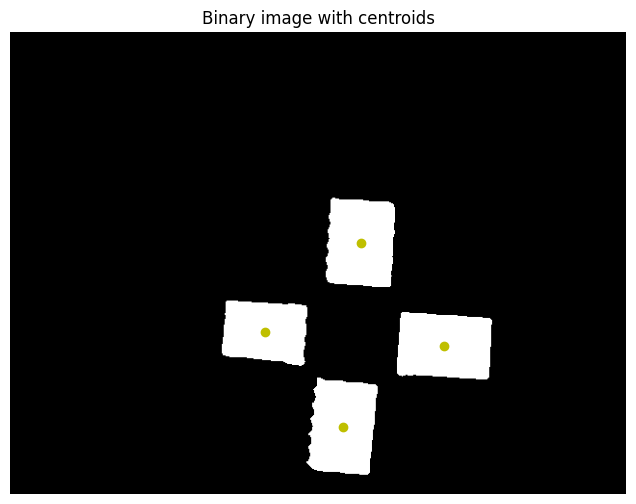

Centroids:
Alvo 1: (np.float64(218.62418573576082), np.float64(363.8847502923))
Alvo 2: (np.float64(310.7628784899725), np.float64(264.800235941801))
Alvo 3: (np.float64(325.79123544631307), np.float64(450.84459896507116))
Alvo 4: (np.float64(409.79499011206326), np.float64(345.18836519446273))


In [32]:
labeled_array, num_features = label(binary_image)
print(f"Number of yellow targets found: {num_features}")

# Calculate centroids of each target 
centroids = center_of_mass(binary_image, labeled_array, range(1, num_features + 1))

plt.figure(figsize=(10, 6))
plt.imshow(binary_image, cmap="gray")
plt.title("Binary image with centroids")
plt.axis("off")

# Add centroids to image
for centroid in centroids:
    plt.plot(centroid[1], centroid[0], "yo")  # (inverted y, x)
plt.show()

print("Centroids:")
for i, centroid in enumerate(centroids, 1):
    print(f"Alvo {i}: {centroid}")